In [7]:
%load_ext pretty_jupyter

The pretty_jupyter extension is already loaded. To reload it, use:
  %reload_ext pretty_jupyter


In [28]:
# -.-|m { input: false, output: false, input_fold: show}

import tomlkit
import scanpy as sc
from anndata import AnnData
from scipy.sparse import issparse

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from  matplotlib import rc_context
import patchworklib as pw


from IPython.display import display
from os import path
import session_info
import logging
from tempfile import TemporaryDirectory 
from os import system

logging.basicConfig(level=logging.ERROR)


# Utility functions

In [9]:
def get_var_features_num(adata: AnnData, variable_features: int|float) -> int:
    detected_gene_nu = len(adata.var_names) 
    if variable_features <= 1:
        return int(detected_gene_nu * variable_features)
    else:
        return min(detected_gene_nu, variable_features)
    

def is_raw_counts(matrix) -> bool:
    if issparse(matrix):
        return matrix.count_nonzero() == matrix.astype("uint32").count_nonzero()
    else:
        return np.count_nonzero(matrix) == np.count_nonzero(matrix.astype("uint32"))
    

# Config

In [10]:
## Pipeline parameters

with open("../config.toml", "r") as f:
    config = tomlkit.parse(f.read())

In [11]:
ROOT_DIR = config["basic"]["ANALYSIS_DIR"]
DIR_SAVE = path.join(ROOT_DIR, config["basic"]["DIR_SAVE"])

NORMALIZATION_METHOD = config["normalization"]["NORMALIZATION_METHOD"]
VARIABLE_FEATURES = config["normalization"]["VARIABLE_FEATURES"]
COUNTS_LAYER = config["normalization"]["COUNTS_LAYER"]
CLUSTERING_RANGE = config["clustering"]["CLUSTERING_RANGE"]
FINAL_RESOLUTION = config["clustering"]["FINAL_RESOLUTION"]

# Reading Files

In [12]:
adata = sc.read_h5ad(path.join(DIR_SAVE, "adata.h5ad"))

# Normalize object

In [13]:
var_features = get_var_features_num(adata, VARIABLE_FEATURES)


if COUNTS_LAYER == "X":
    adata["counts"] = adata.X.copy()
elif COUNTS_LAYER in adata.layers.keys():
    adata.X = adata.layers[COUNTS_LAYER]
else:
    raise ValueError("obj.X seems to be normalized and and the {COUNTS_LAYER} layer can't be found in the object")

if NORMALIZATION_METHOD == "log1p":
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    adata.layers["log_norm"] = adata.X

    # https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.highly_variable_genes.html
    # Similair to Seurat FindVariableFeatures(method='vst') 
    sc.pp.highly_variable_genes(adata, n_top_genes=var_features, batch_key=None, flavor="seurat_v3")

if NORMALIZATION_METHOD == "pearson_residuals":
    # Recipie for variable feature selection, pearson normalization, and PCA
    adata = sc.experimental.pp.recipe_pearson_residuals(adata=adata, n_top_genes = var_features)
    adata["p_residuals"] = adata.X.copy()


# Select Variable Features

number of variable genes is: 3660


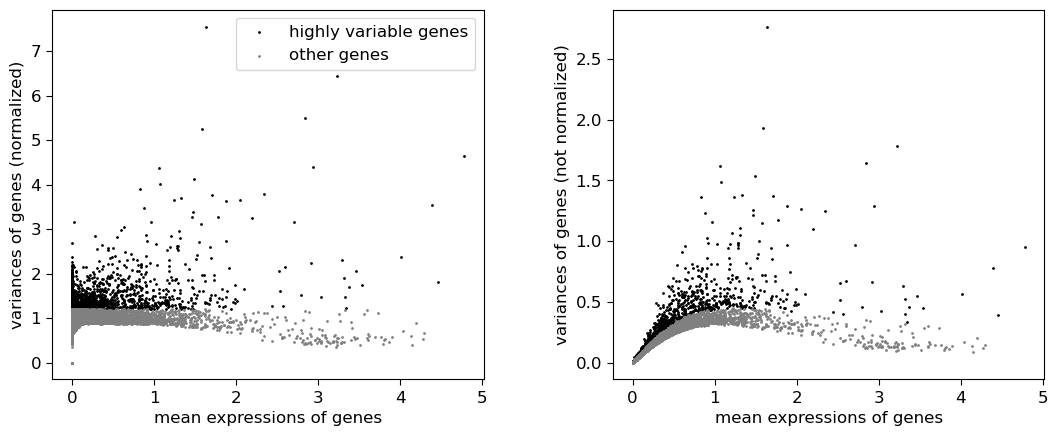

In [15]:
print(f"number of variable genes is: {var_features}")
sc.pl.highly_variable_genes(adata)

# Clustering 

In [ ]:
sc.pp.pca(adata)
sc.tl.umap(adata)

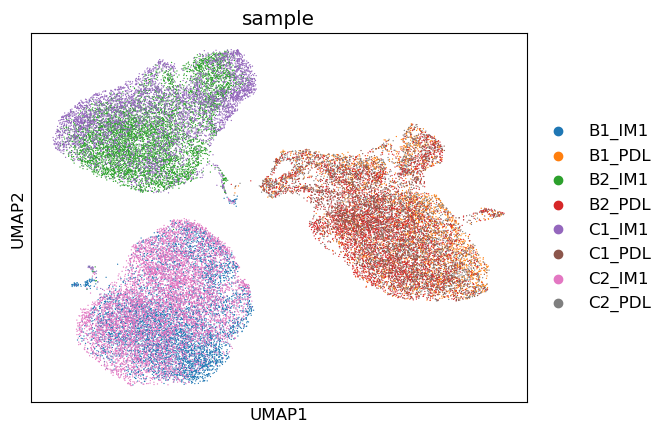

In [17]:
sc.pl.umap(adata, color="sample")

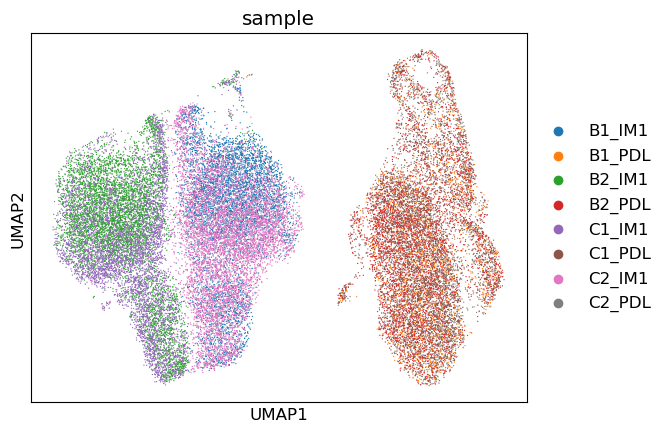

In [18]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color="sample")

In [19]:
for i in np.arange(CLUSTERING_RANGE[0], CLUSTERING_RANGE[1], 0.3):
    resolution = np.around(i, decimals=3)
    sc.tl.leiden(adata=adata, key_added = f"leiden_{resolution}", resolution=resolution)

## Clustree

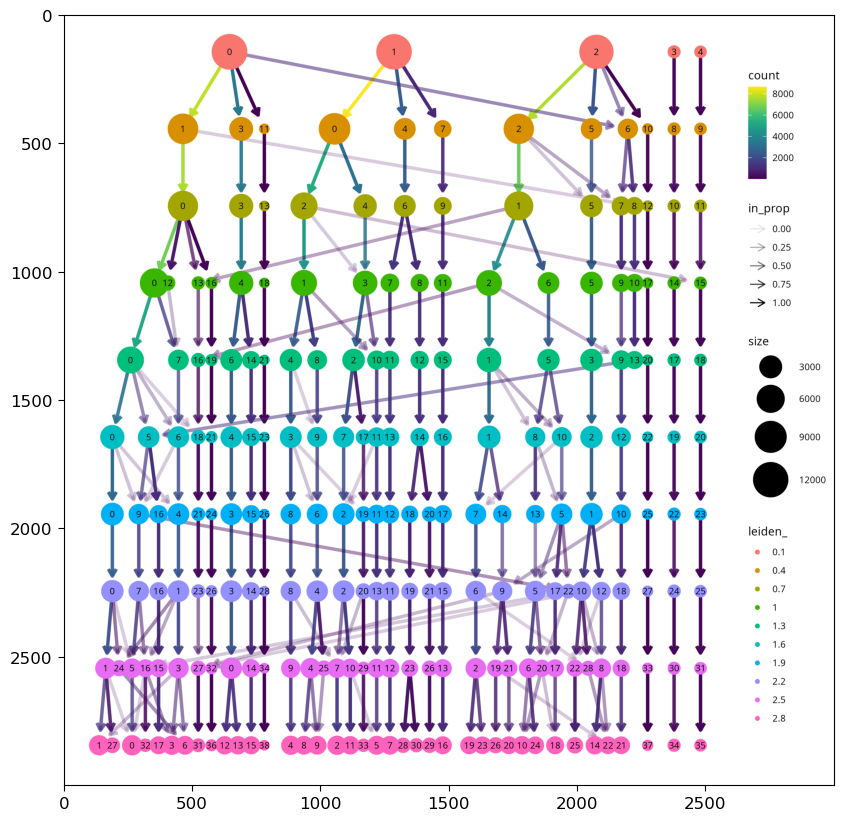

In [30]:
with TemporaryDirectory(dir=".") as f:
    input_dir = path.join(f, "leiden_clusters.csv")
    df = adata.obs.filter(regex= "leiden_")
    df.to_csv(input_dir)
    system(f"Rscript ./clustree.R -i {input_dir} -p leiden_ -o {f}")
    fig = plt.imread(path.join(f, "clustree.png"))


with rc_context({"figure.figsize": (10,10)}):
    plt.imshow(fig)


## Showing all clustering solution

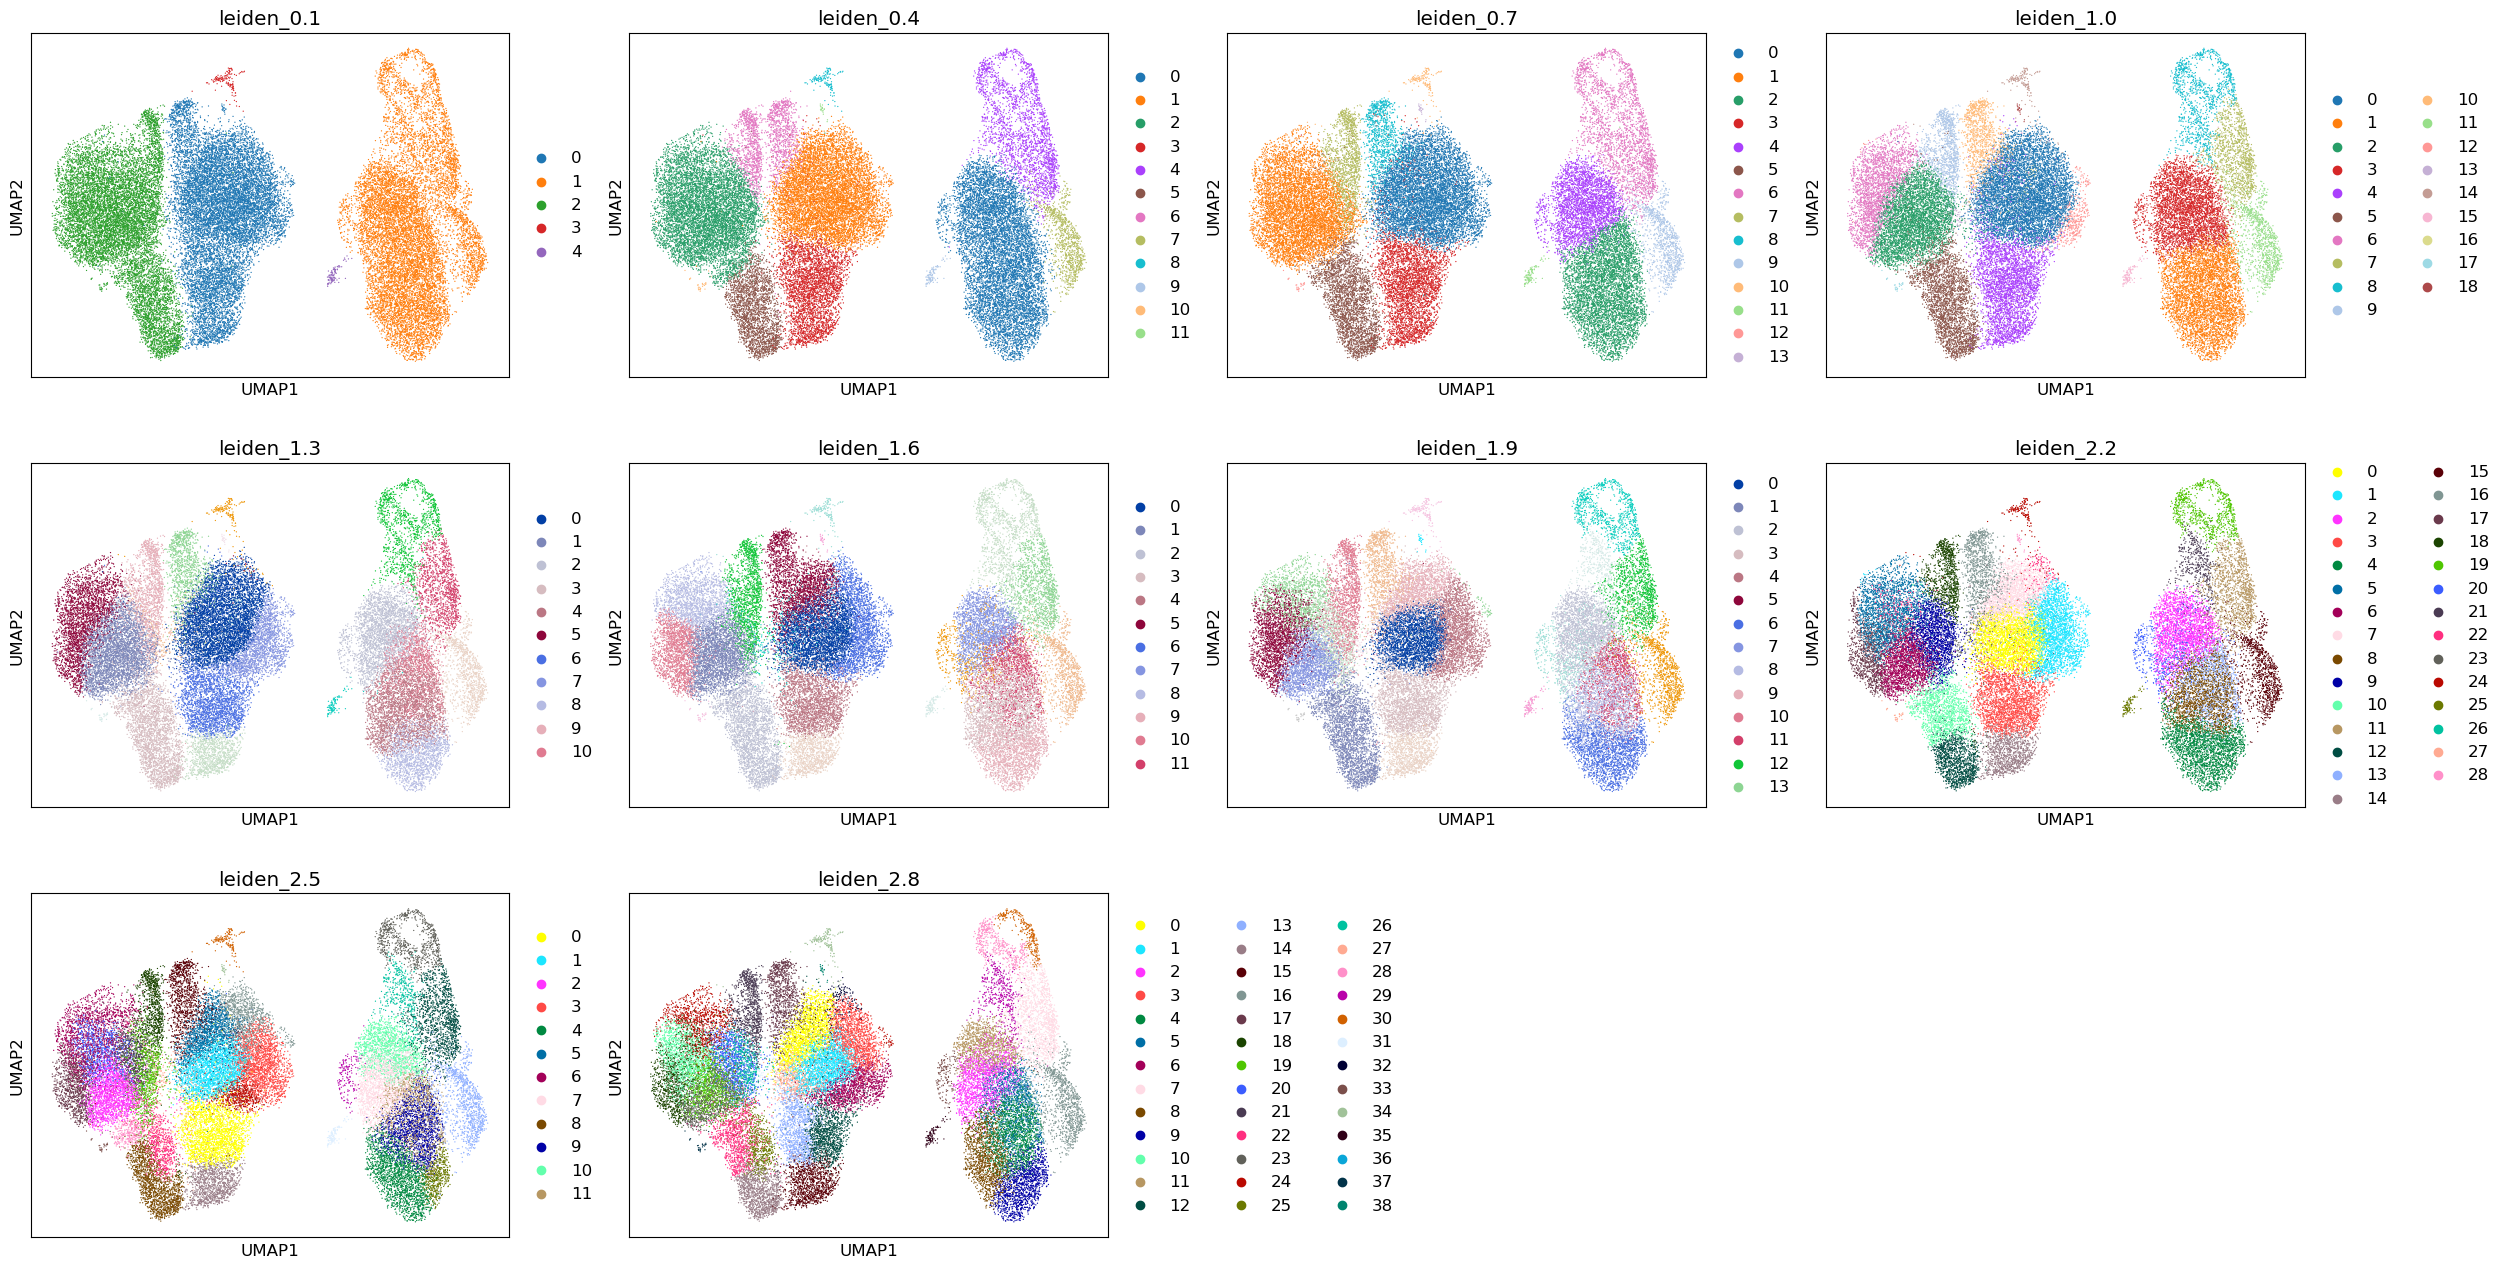

In [38]:
sc.pl.umap(adata, color=adata.obs.filter(regex= "leiden_").columns)

## Modularity

In [39]:
ig_obj = sc.Neighbors(adata).to_igraph()

In [40]:
adata.obs["leiden_0.4"]

AAACCCAAGCTTAAGA-1    0
AAACCCACATATCTGG-1    4
AAACCCAGTACAGCGA-1    7
AAACCCAGTAGGAGGG-1    0
AAACCCATCAACTGGT-1    0
                     ..
TTTGTTGAGCTTCGTA-1    0
TTTGTTGCAGCAGAAC-1    0
TTTGTTGCATGTGGCC-1    0
TTTGTTGGTCATGGCC-1    0
TTTGTTGGTCCGGTCA-1    0
Name: leiden_0.4, Length: 35626, dtype: category
Categories (12, object): ['0', '1', '2', '3', ..., '8', '9', '10', '11']

In [ ]:
ig_obj.modularity(adata.obs["leiden_0.4"])